In [3]:
import os
import itertools
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from palettable.colorbrewer.sequential import YlGn_8
from palettable.wesanderson import Mendl_4
from palettable.cartocolors.sequential import PurpOr_6
from palettable.colorbrewer.diverging import PuOr_7

from ideotype.data_process import read_data, agg_sims, fetch_sim_values, parse_mature
from ideotype.analysis import identify_top_phenos, rank_all_phenos, rank_top_phenos
from ideotype.figures import plot_sims_raw, plot_sims_phenostage
from ideotype.init_params import params_sample
from ideotype.utils import read_sim, fold
from ideotype import DATA_PATH

In [4]:
run_name = 'present'

# Read in data etc.
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)

# set site as int for dataframe emrging purposes
df_all.site = df_all.site.astype(int)
df_stuck.site = df_stuck.site.astype(int)
df_wea.site = df_wea.site.astype(int)

# Queried maizsim outputs
df_sims = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_yield.csv'))
df_phys = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_phys.csv'))
df_carbon = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_carbon.csv'))
df_mass = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_mass.csv'))
df_leaves = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_leaves.csv'))
df_waterdeficit = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit.csv'))
df_waterdeficit_sum = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterdeficit_sum.csv'))
df_waterpotential = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_waterpotential.csv'))
df_phenology = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_pheno.csv'))
start_dates = [int(datetime.strptime(date, '%m/%d/%Y').strftime('%j')) for date in df_phenology.date_start]
df_phenology['jday'] = start_dates
df_gseason_climate = pd.read_csv(os.path.join(DATA_PATH, 'sims', f'sims_{run_name}_gseason_climate.csv'))

In [5]:
# Fetch raw sim values
phenos_ranked = rank_top_phenos('present',20,1,1)
An_sun = fetch_sim_values(df_phys, '"grainFill"', 'An_sun', phenos_ranked)
An_shade = fetch_sim_values(df_phys, '"grainFill"', 'An_shade', phenos_ranked)
LA = fetch_sim_values(df_leaves, '"grainFill"', 'LA', phenos_ranked)
leaves = fetch_sim_values(df_leaves, '"grainFill"', 'leaves', phenos_ranked)
LAI = fetch_sim_values(df_leaves, '"grainFill"', 'LAI', phenos_ranked)
sun_perct = fetch_sim_values(df_phys, '"grainFill"', 'sun_perct', phenos_ranked)
shade_perct = fetch_sim_values(df_phys, '"grainFill"', 'shade_perct', phenos_ranked)

### All parameter values

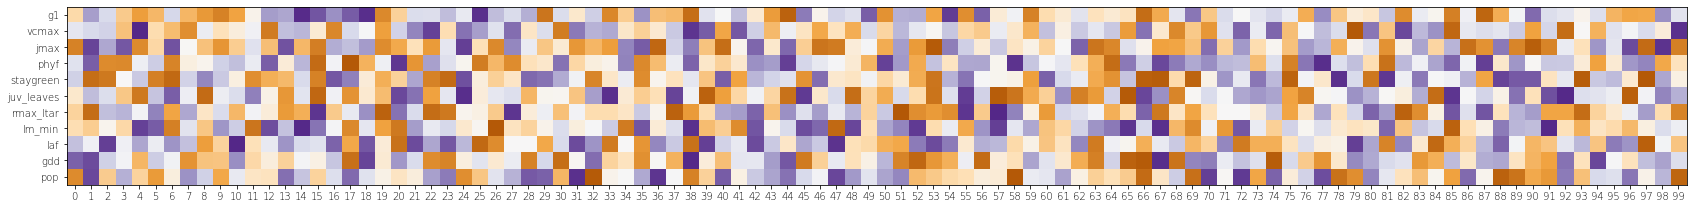

In [6]:
df_params_sub = df_params.iloc[:100,:-1]

problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

for param in params:
    df_params_fold[param] = fold(df_params_sub[param],
                                 param_range[param][0],
                                 param_range[param][1])

# Visualize
fig, ax = plt.subplots(figsize=(30,5))

ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_params_sub.shape[0]))
ax.set_yticks(np.arange(df_params_sub.shape[1]))
ax.set_xticklabels(list(df_params_sub.index),
                   size=10, fontweight='light')
ax.set_yticklabels(list(df_params_sub.columns),
                   size=10, fontweight='light')

fig.subplots_adjust(left=0.15)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_params_all_unranked.png', format='png', dpi=800)

## Parameters to parameters

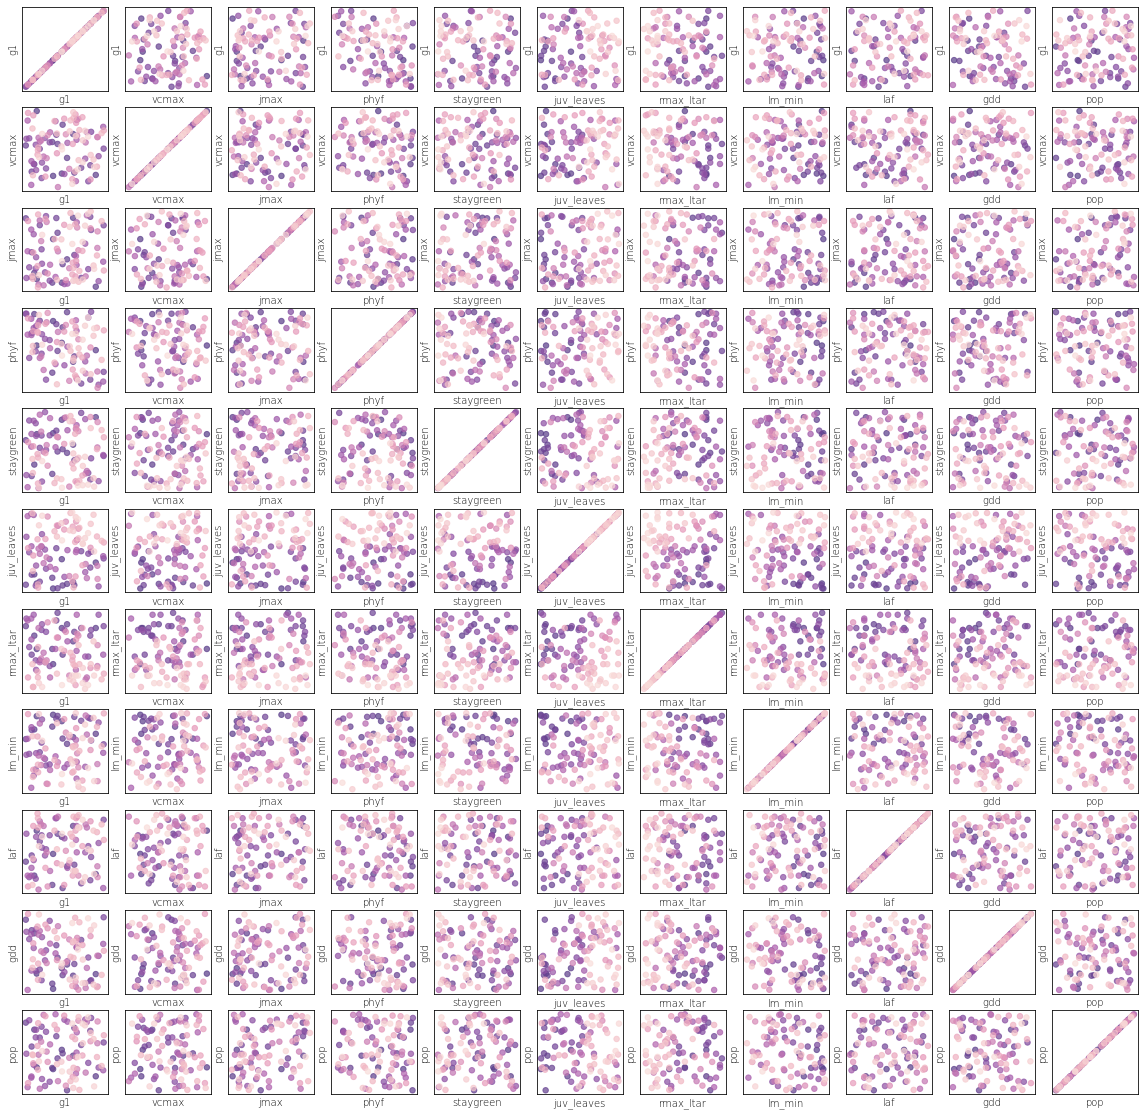

In [7]:
params = df_params.columns[:-1]

fig, axs = plt.subplots(11,11, figsize=(20,20))
for count_x, param_x in enumerate(params):
        
    for count_y, param_y in enumerate(params):
        ax = axs[count_y, count_x]
        ax.scatter(df_params_sub[param_x], df_params_sub[param_y], 
                   c=np.arange(100), cmap=PurpOr_6.mpl_colormap.reversed(), 
                   alpha=0.7, s=30)

        ax.set_xlabel(param_x, fontweight='light')
        ax.set_ylabel(param_y, fontweight='light')            
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

fig.subplots_adjust(wspace=0.2, hspace=0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_all.png', format='png', dpi=800)

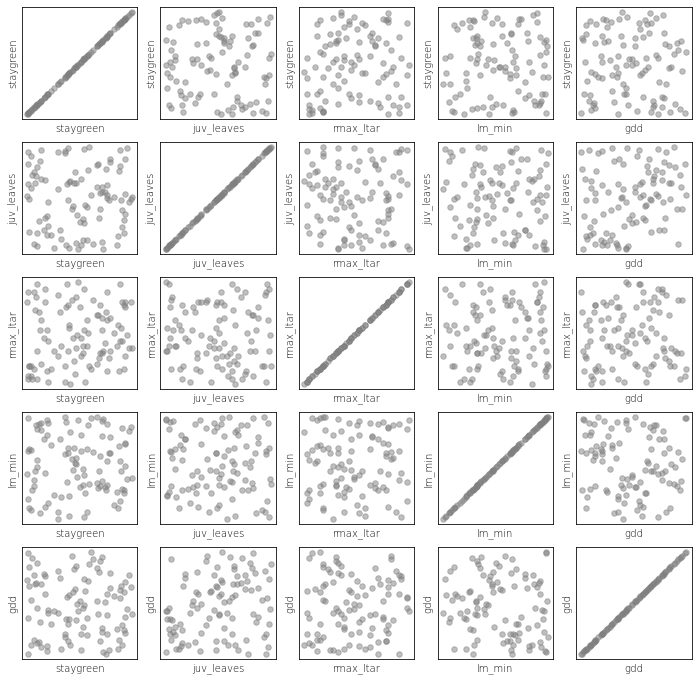

In [17]:
params_sub = ['staygreen', 'juv_leaves', 'rmax_ltar', 'lm_min', 'gdd']

fig, axs = plt.subplots(5,5, figsize=(12,12))
for count_x, param_x in enumerate(params_sub):
        
    for count_y, param_y in enumerate(params_sub):
        ax = axs[count_y, count_x]
        ax.scatter(df_params_sub[param_x], df_params_sub[param_y], 
                   c='grey',
                   alpha=0.5, s=30)

        ax.set_xlabel(param_x, fontweight='light')
        ax.set_ylabel(param_y, fontweight='light')
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

fig.subplots_adjust(wspace=0.2, hspace=0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_targeted_greyscale.png', format='png', dpi=800)

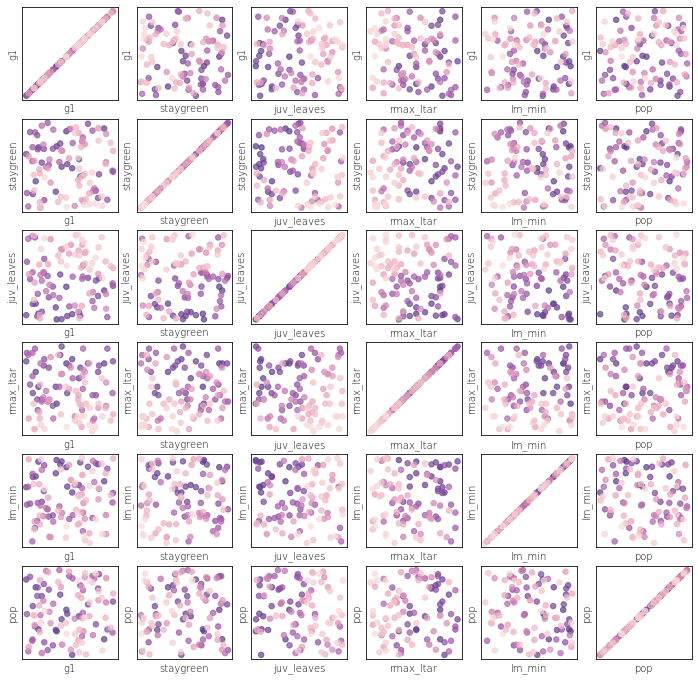

In [139]:
# rank all phenos
phenos_ranked = rank_top_phenos('present', 100, 1, 1)

# put together params info
df_params_s = df_params.iloc[:,:-1][:100]
df_params_sub = df_params_s.iloc[phenos_ranked]

# targeted params
params_sub = ['g1', 'staygreen', 'juv_leaves', 'rmax_ltar', 'lm_min', 'pop']

fig, axs = plt.subplots(6,6, figsize=(12,12))
for count_x, param_x in enumerate(params_sub):
        
    for count_y, param_y in enumerate(params_sub):
        ax = axs[count_y, count_x]
        ax.scatter(df_params_sub[param_x], df_params_sub[param_y], 
                   c=np.arange(100), cmap=PurpOr_6.mpl_colormap.reversed(), 
                   alpha=0.7, s=30)

        ax.set_xlabel(param_x, fontweight='light')
        ax.set_ylabel(param_y, fontweight='light')    
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

fig.subplots_adjust(wspace=0.2, hspace=0.2)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_targeted.png', format='png', dpi=800)

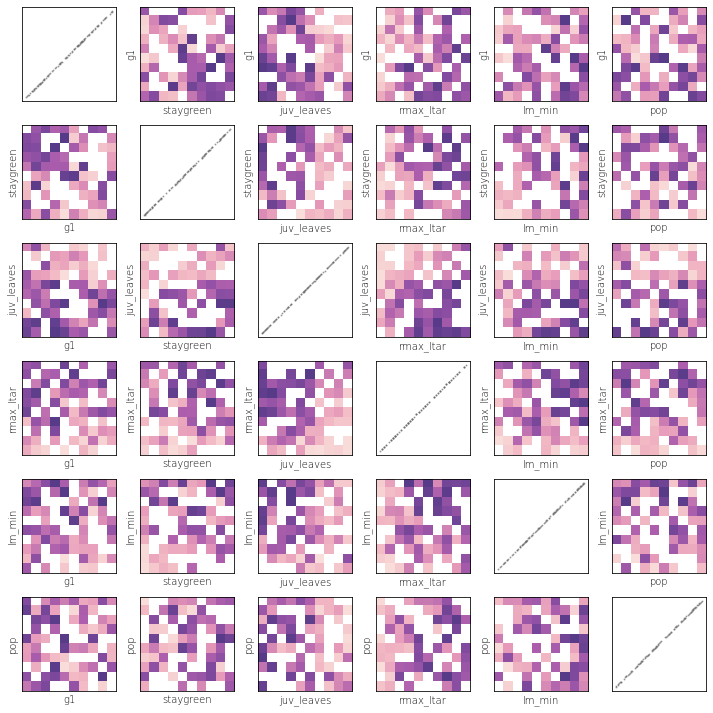

In [8]:
# rank all phenos
phenos_ranked = rank_top_phenos('present', 100, 1, 1)

# put together params info
df_params_s = df_params.iloc[:,:-1][:100]
df_params_sub = df_params_s.iloc[phenos_ranked]

# target phenos
df_params_sub_target = df_params_sub[['g1', 'staygreen', 'juv_leaves', 'rmax_ltar', 'lm_min', 'pop']]
num_params = df_params_sub_target.shape[1]
params = df_params_sub_target.columns
ranks = np.arange(100)

plotting_order = []
for p1 in np.arange(num_params):
    for p2 in np.arange(num_params):
        plotting_order.append((params[p2], params[p1])) # switch to match x-y label

fig, axs = plt.subplots(6,6, figsize=(10,10))

for ax, param in zip(axs.flatten(), plotting_order):
    px = param[0]
    py = param[1]
    x = df_params_sub[px]
    y = df_params_sub[py]

    if px == py:
        ax.scatter(x, y, color='dimgrey', alpha=0.5, s=1)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

    else:
        ranks = np.arange(100)
        df_sub = pd.DataFrame([x, y])
        df_sub = df_sub.transpose()
        df_sub['ranks'] = ranks
        px_bin = pd.cut(df_sub.loc[:,px], 10, labels=False)
        py_bin = pd.cut(df_sub.loc[:,py], 10, labels=False)
        df_sub['px_bin'] = px_bin
        df_sub['py_bin'] = py_bin
        
        rank_list = []
        for py_cat in reversed(range(len(set(py_bin)))):
            sub_list = []
            for px_cat in range(len(set(px_bin))):
                mean_rank = df_sub[(df_sub['px_bin']==px_cat) & (df_sub['py_bin']==py_cat)].ranks.mean()
                sub_list.append(mean_rank)
            rank_list.append(sub_list)
        ax.imshow(rank_list, cmap=PurpOr_6.mpl_colormap.reversed())

        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

        ax.set_xlabel(param[0], fontweight='light')
        ax.set_ylabel(param[1], fontweight='light')

fig.subplots_adjust(left=0.05, bottom=0.05, right=1, top=1, wspace=0.25, hspace=0.25)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/param_pairplot_heatmap_targeted.png', format='png', dpi=800)

## Parameters to emergent properties

In [124]:
# fetch emergent properties
phenos_ranked = rank_top_phenos('present', 100, 1, 1)
df_pheno_gf = df_phenology[df_phenology.pheno == '"grainFill"']

# grain-filling length
gf_lengths = []
for pheno in phenos_ranked:
    df_sub = df_pheno_gf.query(f'cvar=={pheno}')
    gf_length = df_sub.mean()['pheno_days']
    gf_lengths.append(gf_length)
    
# grain-filling length
gf_startdates = []
for pheno in phenos_ranked:
    df_sub = df_pheno_gf.query(f'cvar=={pheno}')
    gf_startdate = df_sub.mean()['jday']
    gf_startdates.append(gf_startdate)
    
# leaf areas
LAs = fetch_sim_values(df_leaves, '"grainFill"', 'LA', phenos_ranked)

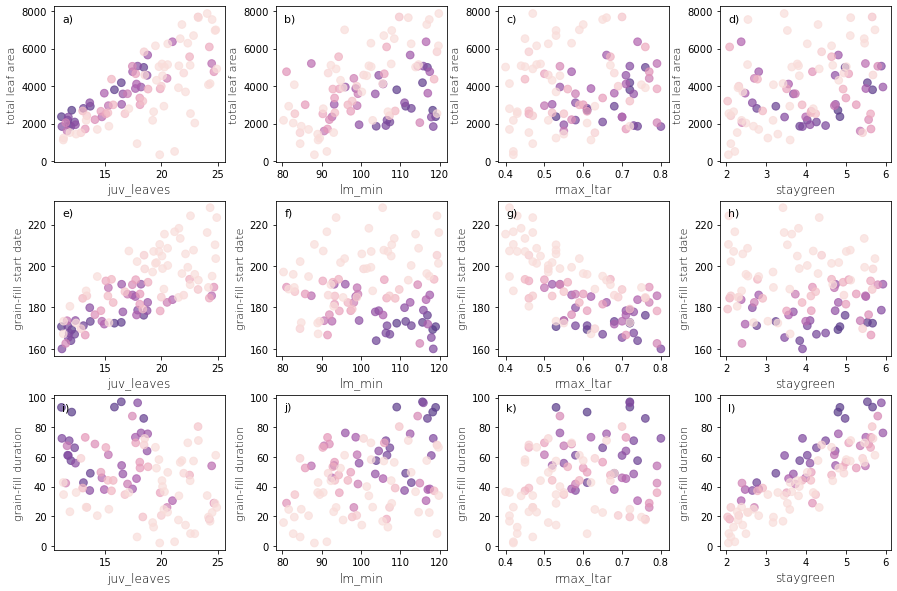

In [231]:
# set up iterables
params = ['juv_leaves', 'lm_min', 'rmax_ltar', 'staygreen']
emps = [LAs, gf_startdates, gf_lengths]
emps_text = ['total leaf area', 'grain-fill start date', 'grain-fill duration']
alphabets = np.matrix([['a','e','i'],['b','f','j'],['c','g','k'],['d','h','l']])

# visualiztion
fig, axs = plt.subplots(len(emps), len(params), figsize=(15,10))
for count_x, param in enumerate(params):
    for count_y, emp in enumerate(emps):
        ax = axs[count_y, count_x]
        ax.scatter(df_params_sub.reindex(phenos_ranked)[param], emp, 
                   c=np.arange(100), cmap=PurpOr_6.mpl_colormap.reversed(), 
                   alpha=0.7, s=60, vmax=60)
        ax.set_xlabel(param, fontweight='light', fontsize=12)
        ax.set_ylabel(emps_text[count_y], fontweight='light', fontsize=11)
        ax.annotate(f'{alphabets[count_x, count_y]})', xy=(0.05, 0.9), 
                    xycoords='axes fraction', fontsize=11)

fig.subplots_adjust(wspace=0.3, hspace=0.25)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_emergent_properties.png', format='png', dpi=800)

In [7]:
# grain-fill start date & duration
df_pheno_grouped = df_phenology[
    df_phenology.pheno == '"grainFill"'].groupby(
    ['cvar','site']).mean().reset_index()[['cvar','site','pheno_days', 'jday']]

# edate
df_pheno_gdate = df_phenology[
    df_phenology.pheno == '"Emerged"'].groupby(
    ['cvar','site']).mean().reset_index()[['cvar','site','jday']]
df_pheno_gdate.columns = ['cvar','site','edate']
df_pheno_grouped = df_pheno_grouped.merge(df_pheno_gdate, how='left', on=['cvar','site'])

# photosynthesis
df_phys_grouped = df_phys[
    df_phys.pheno=='"grainFill"'].groupby(
    ['cvar','site']).mean().reset_index()[['cvar','site','An', 'gs']]

# water deficit
df_wdsum = df_waterdeficit[
    df_waterdeficit.pheno == '"Emerged"'].groupby(
    ['cvar','site']).mean().reset_index()[['cvar','site','water_deficit_mean']]

# leaf area
df_leaves_grouped = df_leaves[
    df_leaves.pheno == '"Tasselinit"'].groupby(
    ['cvar','site']).mean().reset_index()[['cvar','site','LA']]

# merge all
df_emps = df_pheno_grouped.merge(df_phys_grouped, how='left', on=['cvar','site'])
df_emps = df_emps.merge(df_leaves_grouped, how='left', on=['cvar', 'site'])
df_emps = df_emps.merge(df_wdsum, how='left', on=['cvar', 'site'])


# average within each phenotype
df_emps = df_emps.groupby('cvar').mean()

# merge with param for correlation
df_corr = pd.concat([df_emps, df_params_sub], axis=1)
df_corr.dropna(axis=0, inplace=True)

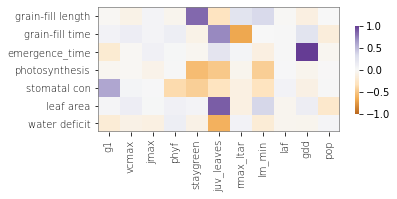

In [8]:
# set up iterables
params = ['g1', 'vcmax', 'jmax', 'phyf', 'staygreen',
          'juv_leaves', 'rmax_ltar', 'lm_min', 'laf', 'gdd', 'pop']
emps = df_emps.columns[1:]
emps_text = ['grain-fill length', 'grain-fill time', 'emergence_time',
             'photosynthesis', 'stomatal con',
             'leaf area', 'water deficit']


# calculate correlation coefficient
mx_corr = np.zeros((len(emps), len(params)))
for count_x, param in enumerate(params):
    for count_y, emp in enumerate(emps):
        x = df_corr[param]
        y = df_corr[emp]
        corr = round(np.corrcoef(x,y)[0,1],2)
        mx_corr[count_y, count_x] = corr
        
# visualization
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1,1,1)

hmap = sns.heatmap(mx_corr, cmap=PuOr_7.mpl_colormap, alpha=0.9,
                   cbar_kws={'shrink': 0.7}, vmin=-1, vmax=1)

hmap.axhline(y = 0, color='grey',linewidth=1.5)
hmap.axhline(y = mx_corr.shape[0], color='grey', linewidth=1.5)

hmap.axvline(x = 0, color='grey', linewidth=1.5)
hmap.axvline(x = mx_corr.shape[1], color='grey', linewidth=1.5)

ax.set_xticks(np.arange(0.5, len(params)+0.5))
#ax.set_xticks(np.arange(0, len(params)))
ax.set_xticklabels(params, fontsize=10, fontweight='light',
                   rotation=90)
ax.set_yticks(np.arange(0.5, len(emps)+0.5))
ax.set_yticklabels(emps_text, fontsize=10, 
                   fontweight='light', rotation=0)

fig.subplots_adjust(left=0.3, bottom=0.3)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_params_emp.png', format='png', dpi=800)

### Canopy size & water deficit
This is still a mystery to me..

Text(0, 0.5, 'leaf area')

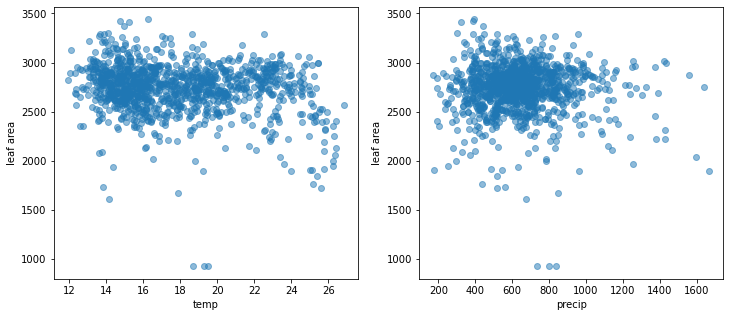

In [19]:
# relationship between temp & leaf area

pheno_stage = '"Tasseled"'
pheno = 4

df_leaves_sub = df_leaves[df_leaves.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')
df_leaves_sub_merged = df_leaves_sub.merge(df_wea, on=['site','year'])

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_leaves_sub_merged.temp, df_leaves_sub_merged.LA, alpha=0.5)
ax1.set_xlabel('temp')
ax1.set_ylabel('leaf area')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_leaves_sub_merged.precip, df_leaves_sub_merged.LA, alpha=0.5)
ax2.set_xlabel('precip')
ax2.set_ylabel('leaf area')

# *note
# didn't really pick up any relationship between climate factor & leaf area

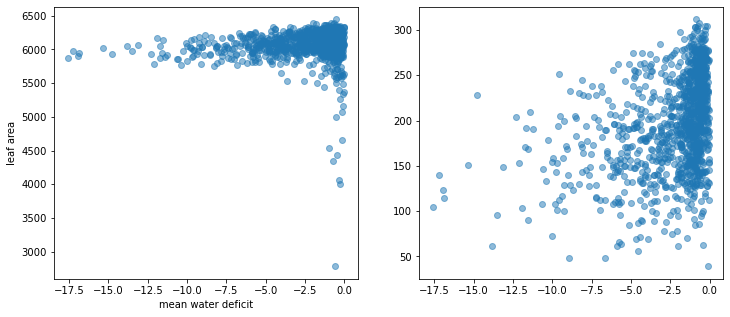

In [169]:
pheno_stage = '"Tasselinit"'
pheno=38

# fetch leaf info
df_leaves_sub = df_leaves[df_leaves.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')

# fetch water deficit info
df_wd_sub = df_waterdeficit[df_waterdeficit.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')

# merge leaf, water deficit, & wea info
df_leaves_wd_merged = df_leaves_sub.merge(df_wd_sub, on=['cvar', 'site', 'year', 'pheno'])
df_leaves_wd_merged = df_leaves_wd_merged.merge(df_wea, on=['site','year'])

# remove datapoints from sims that were stuck
index_stuck = df_leaves_wd_merged.reset_index().merge(
    df_stuck, how='inner', on=['cvar','site','year'])['index']
df_leaves_wd_merged = df_leaves_wd_merged.drop(index_stuck)
df_merged = df_leaves_wd_merged.merge(df_all, how='left', on=['cvar', 'site', 'year'])

# remove sims that didn't make it to maturity
df_merged = df_merged[~df_merged.dm_ear.isna()]

# visualization
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_merged.water_deficit_mean, df_merged.LA_x, alpha=0.5)
ax1.set_xlabel('mean water deficit')
ax1.set_ylabel('leaf area')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_merged.water_deficit_mean, df_merged.dm_ear, alpha=0.5)

In [147]:
df_merged[df_merged.dm_ear.isna()]

cvar    site  year         pheno  LAI_x    LA_x  leaves_x  leaves_mature  \
194    38  722560  1973  "Tasselinit"   0.59  917.68      8.54            8.0   

     leaves_dropped  water_deficit_mean  ...  texture  temp_y  temp_var_y  \
194             6.0               0.055  ...      NaN     NaN         NaN   

     rh_y  rh_var_y  vpd_y  precip_y  precip_var_y  solrad_y  solrad_var_y  
194   NaN       NaN    NaN       NaN           NaN       NaN           NaN  

[1 rows x 100 columns]

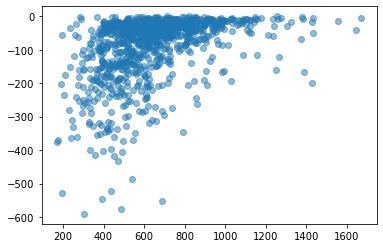

In [140]:
# Relationship between precip & water deficit
plt.scatter(df_merged.precip_x,
            df_merged.water_deficit_sum, alpha=0.5)

# *note
# ok, at least we do see water deficit correlate with precip.

Text(0, 0.5, 'yield')

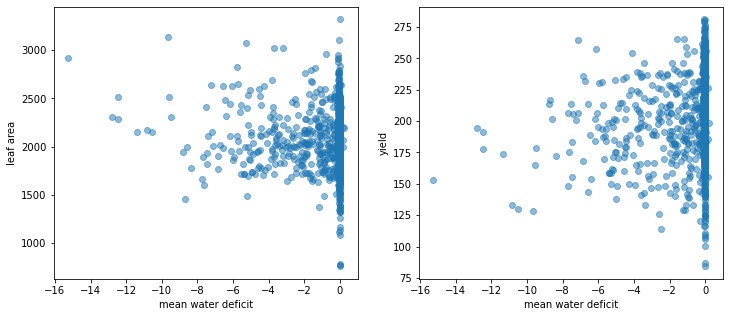

In [143]:
pheno_stage = '"Tasselinit"'
pheno=4

# fetch leaf info
df_leaves_sub = df_leaves[df_leaves.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')

# fetch water deficit info
df_wd_sub = df_waterdeficit[df_waterdeficit.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')

# merge leaf, water deficit, & wea info
df_leaves_wd_merged = df_leaves_sub.merge(df_wd_sub, on=['cvar', 'site', 'year', 'pheno'])
df_leaves_wd_merged = df_leaves_wd_merged.merge(df_wea, on=['site','year'])

# remove datapoints from sims that were stuck
index_stuck = df_leaves_wd_merged.reset_index().merge(
    df_stuck, how='inner', on=['cvar','site','year'])['index']
df_leaves_wd_merged = df_leaves_wd_merged.drop(index_stuck)
df_merged = df_leaves_wd_merged.merge(df_all, how='left', on=['cvar', 'site', 'year'])

# visualization
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_merged.water_deficit_mean, df_merged.LA_x, alpha=0.5)
ax1.set_xlabel('mean water deficit')
ax1.set_ylabel('leaf area')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_merged.water_deficit_mean, df_merged.dm_ear, alpha=0.5)
ax2.set_xlabel('mean water deficit')
ax2.set_ylabel('yield')

In [145]:
df_merged[df_merged.dm_ear.isna()]

cvar    site  year         pheno  LAI_x    LA_x  leaves_x  leaves_mature  \
197     4  722560  1973  "Tasselinit"    1.6  2217.5      12.0            9.0   

     leaves_dropped  water_deficit_mean  ...  texture  temp_y  temp_var_y  \
197             3.0            -0.03212  ...      NaN     NaN         NaN   

     rh_y  rh_var_y  vpd_y  precip_y  precip_var_y  solrad_y  solrad_var_y  
197   NaN       NaN    NaN       NaN           NaN       NaN           NaN  

[1 rows x 100 columns]

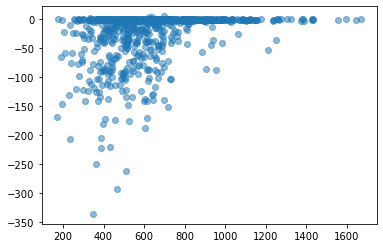

In [142]:
plt.scatter(df_merged.precip_x,
            df_merged.water_deficit_sum, alpha=0.5)

There's something weird about water deficit & leaf area <br/>
In general, higher leaf area leads to greater yield within the same phenotype. An in theory, water deficit will lower leaf area to some degree. However, we see that most of the really low leaf area sims happen when there's close to 0 water deficit. This translates into weird patterns in final yield. This is probably something important to yield volatility, and if its due to a modeling artifact (I'm suspecting something to do with soil type, or soil interaction with precip early in gsason),  will really need to fix it. 

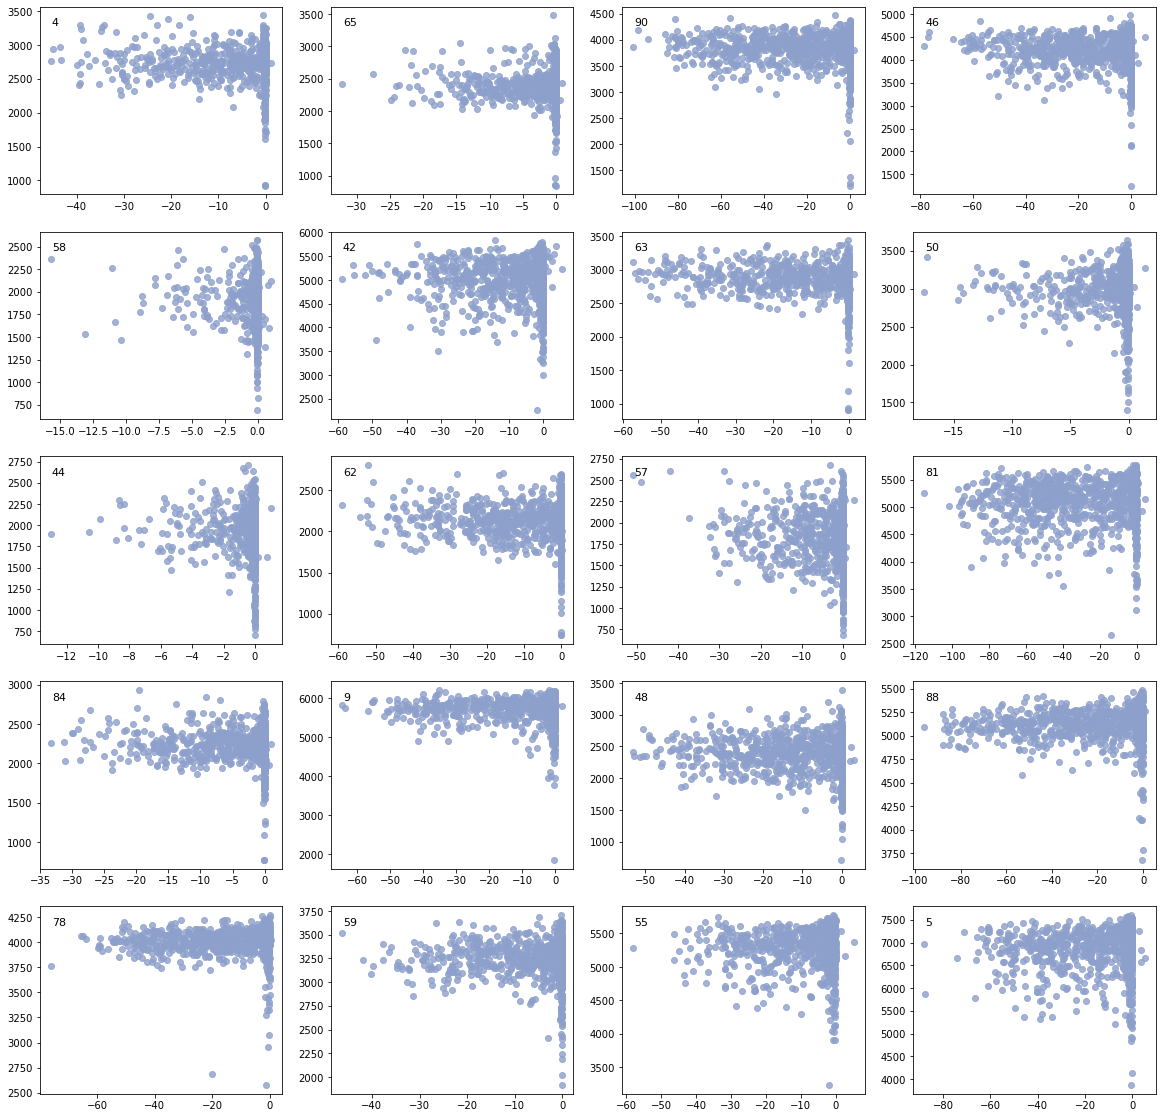

In [170]:
# leaf area & water deficit

pheno_stage = '"Tasseled"'
phenos = rank_top_phenos('present',20,1,1)[:20]

fig = plt.figure(figsize=(20,20))
for item, pheno in enumerate(phenos):
    df_leaves_sub = df_leaves[df_leaves.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')
    df_wd_sub = df_waterdeficit[df_waterdeficit.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')
    df_leaves_wd_merged = df_leaves_sub.merge(df_wd_sub, on=['cvar', 'site', 'year', 'pheno'])
    df_leaves_wd_merged = df_leaves_wd_merged.merge(df_wea, on=['site','year'])
    
    # remove datapoints from sims that were stuck
    index_stuck = df_leaves_wd_merged.reset_index().merge(
        df_stuck, how='inner', on=['cvar','site','year'])['index']
    df_leaves_wd_merged = df_leaves_wd_merged.drop(index_stuck)
    df_merged = df_leaves_wd_merged.merge(df_all, how='left', on=['cvar', 'site', 'year'])

    # remove sims that didn't make it to maturity
    df_merged = df_merged[~df_merged.dm_ear.isna()]

    ax = fig.add_subplot(5,4,item+1)
    ax.scatter(df_leaves_wd_merged.water_deficit_mean, df_leaves_wd_merged.LA, 
               color='#8da0cb', alpha=0.8)
    ax.annotate(pheno, xy=(0.05, 0.9), 
            xycoords='axes fraction', fontsize=11)

In general, we see pretty strong correlation between LA & yield, so whatever is causing the sims to have much lower LA at low water deficit could be a big cause contributing to yield dispersion (although now that I'm looking again, it seems like many sims with high LA also get low yield). Regardless, this seems like an odd model behavior. Trying to get to the bottom of it.

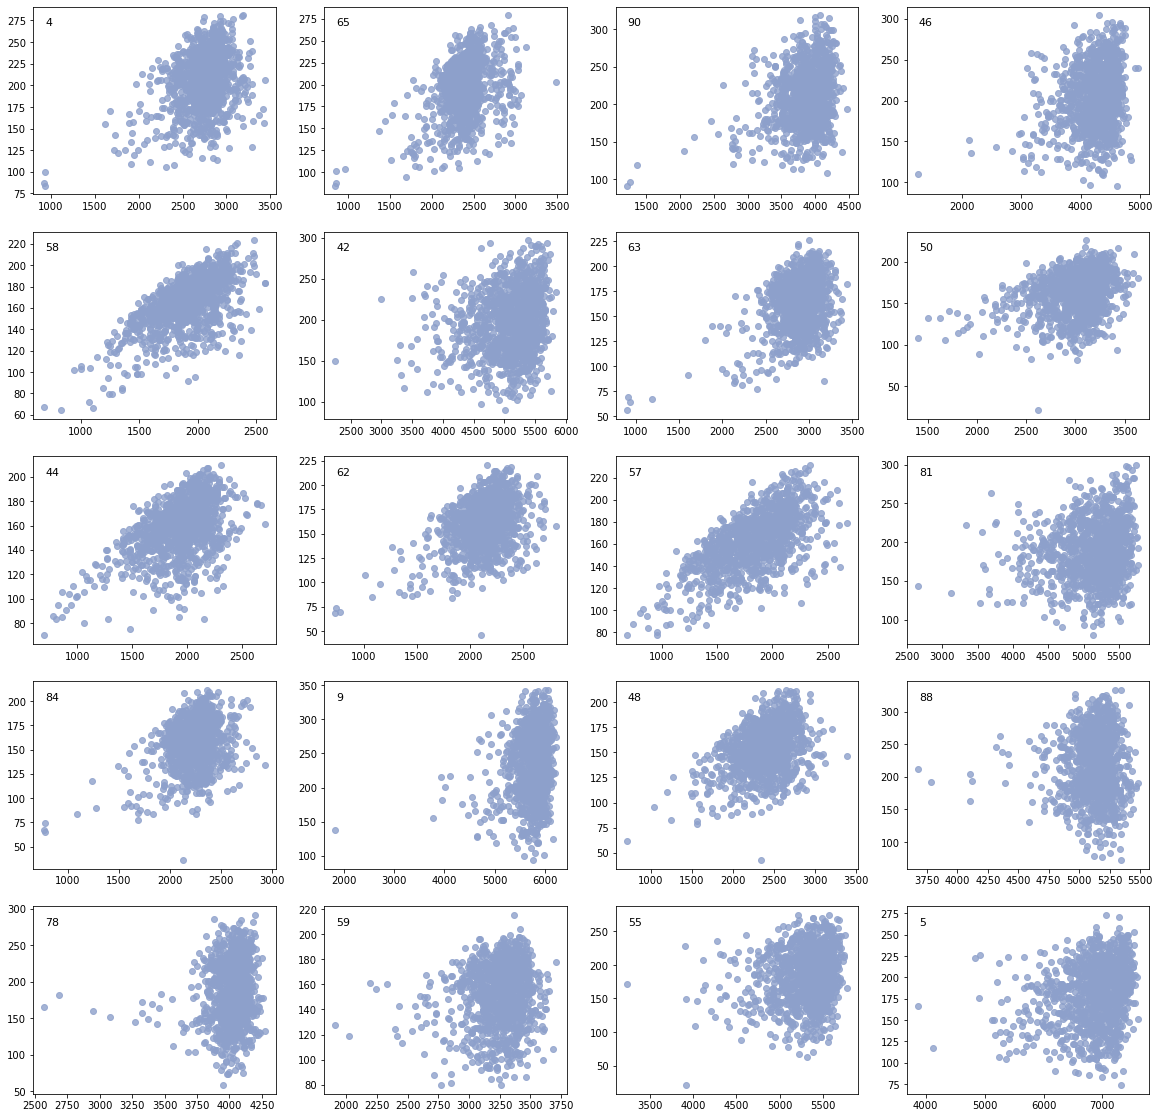

In [171]:
# leaf area & yield

pheno_stage = '"Tasseled"'
phenos = rank_top_phenos('present',20,1,1)[:20]

fig = plt.figure(figsize=(20,20))
for item, pheno in enumerate(phenos):
    df_leaves_sub = df_leaves[df_leaves.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')
    df_wd_sub = df_waterdeficit[df_waterdeficit.pheno == f'{pheno_stage}'].query(f'cvar=={pheno}')
    df_leaves_sub_merged = df_leaves_sub.merge(df_wd_sub, on=['cvar', 'site', 'year','pheno'])    
    df_leaves_sub_merged = df_leaves_sub.merge(df_all, on=['cvar', 'site', 'year'])
    df_leaves_sub_merged = df_leaves_sub_merged.merge(df_wea, on=['site','year'])

    # remove datapoints from sims that were stuck
    index_stuck = df_leaves_wd_merged.reset_index().merge(
        df_stuck, how='inner', on=['cvar','site','year'])['index']
    df_leaves_wd_merged = df_leaves_wd_merged.drop(index_stuck)
    df_merged = df_leaves_wd_merged.merge(df_all, how='left', on=['cvar', 'site', 'year'])

    # remove sims that didn't make it to maturity
    df_merged = df_merged[~df_merged.dm_ear.isna()]
    
    ax = fig.add_subplot(5,4,item+1)
    ax.scatter(df_leaves_sub_merged.LA_x, df_leaves_sub_merged.dm_ear, 
               color='#8da0cb', alpha=0.8)
    ax.annotate(pheno, xy=(0.05, 0.9), 
            xycoords='axes fraction', fontsize=11)

## Precipitation

Checking out raw sim data to try and figure out what's up: <br/>
This particular sim has really low leaf area compared to sims in other site-years of the same phenotype. <br/>
Seems like gs doesn't directly link with photosynthesis, which makes sense since it's linked through the BB equation.

In [4]:
test_sim = read_sim('present', 1983, 724650, 44)

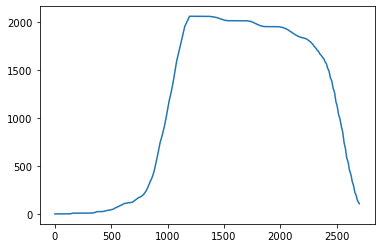

In [6]:
plt.plot(test_sim.LA)

In [688]:
df_wea.query('site==724650')

site  year   temp  temp_var     rh     rh_var   vpd  precip  \
52    724650  1982  15.63  5.322820  59.98   8.658317  0.72  565.50   
164   724650  1974  15.86  5.516565  58.44   9.850063  0.75  271.10   
215   724650  1991  16.96  4.943495  60.46   8.753554  0.77  498.60   
356   724650  1992  15.89  4.187563  63.41   8.568701  0.67  501.00   
368   724650  1987  16.66  5.886949  60.75   9.262453  0.75  435.10   
380   724650  1995  15.04  7.169577  68.70   7.538461  0.54  487.40   
386   724650  1999  15.65  5.743408  64.69   7.846925  0.63  463.00   
597   724650  2000  17.24  5.808256  56.93  10.544906  0.86  329.40   
619   724650  1964  16.21  7.388649  53.81  12.410813  0.86  250.80   
823   724650  1988  16.99  6.185297  57.33  10.065857  0.83  465.90   
883   724650  1983  16.41  7.283702  58.28   8.844329  0.79  367.10   
888   724650  1975  15.29  6.750456  57.75   9.719717  0.74  376.30   
980   724650  1990  16.86  5.759514  60.84  10.033414  0.76  404.30   
1051  724650  1981  16.41  4.861010  60.88   8.843352  0.74  460.45   
1133  724650  1994  16.90  5.413932  59.87  10.087625  0.78  262.10   

      precip_var  solrad  solrad_var  
52      0.001948  242.28  385.186221  
164     0.000855  254.85  384.274068  
215     0.002047  244.84  404.085443  
356     0.002680  232.46  396.125299  
368     0.001393  256.84  396.058086  
380     0.000952  233.33  409.222178  
386     0.001937  250.31  419.415245  
597     0.001413  258.06  402.715238  
619     0.001642  249.58  391.305118  
823     0.001721  260.32  395.036839  
883     0.001557  248.49  387.133526  
888     0.002459  250.87  389.673528  
980     0.001034  255.78  393.072399  
1051    0.000801  248.26  378.631986  
1133    0.001232  258.72  407.668699

In [623]:
jday_start = int(datetime.strptime(test_sim.loc[0,'date'], '%m/%d/%Y').strftime('%j'))
jday_end = int(datetime.strptime(test_sim.iloc[-1]['date'], '%m/%d/%Y').strftime('%j'))

In [625]:
wea_siteyear = pd.read_csv(f'/home/disk/eos8/ach315/upscale/weadata/data/control/724650_1983.txt', sep='\t')

In [637]:
test_wea = wea_siteyear.query(f'{jday_start}<=jday<={jday_end}')[:-11]

In [638]:
test_sim_day = test_sim.query('Solrad > 500')
test_sim_noon = test_sim.query('time==12')

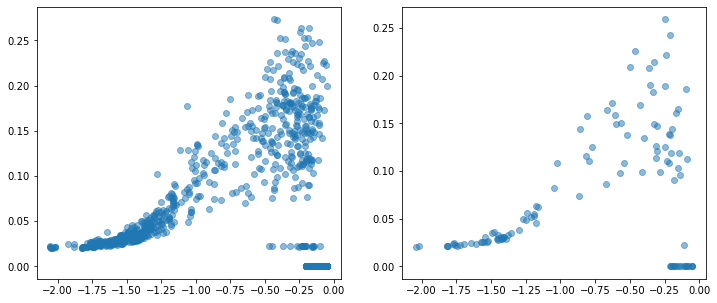

In [649]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(test_sim_day.leaf_WP, test_sim_day.av_gs, alpha=0.5)
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(test_sim_noon.leaf_WP, test_sim_noon.av_gs, alpha=0.5)

In [666]:
list(set(test_sim_day.note))

['              "none"',
 '           "Emerged"',
 '            "Silked"',
 '         "grainFill"',
 '           "Matured"',
 '          "Tasseled"',
 '        "Tasselinit"',
 '        "Germinated"']

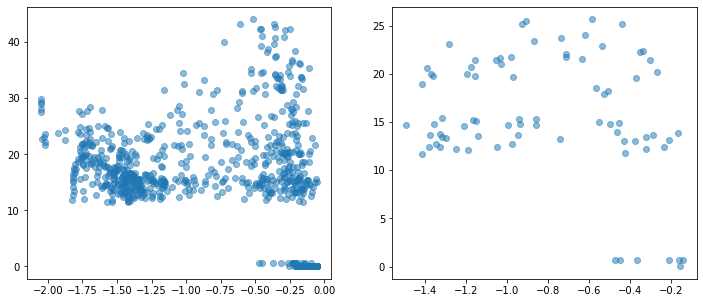

In [683]:
test_sim_day_pheno = test_sim_day[test_sim_day.note==list(set(test_sim_day.note))[2]]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(test_sim_day.leaf_WP, test_sim_day.An_shaded, alpha=0.5)
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(test_sim_day_pheno.leaf_WP, test_sim_day_pheno.An_shaded, alpha=0.5)

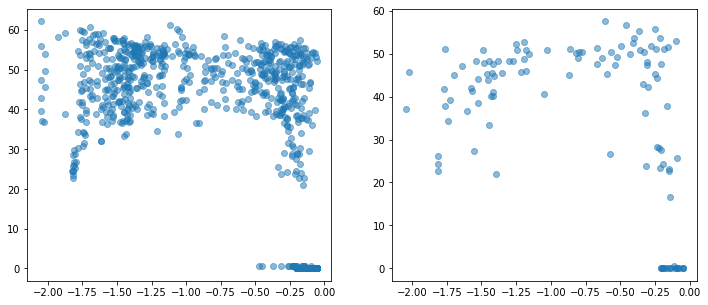

In [650]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(test_sim_day.leaf_WP, test_sim_day.An_sunlit, alpha=0.5)
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(test_sim_noon.leaf_WP, test_sim_noon.An_sunlit, alpha=0.5)

In [490]:
pheno_stage = '"Emerged"'
cvar = 4

df_pheno_sub = df_phenology[df_phenology.pheno == f'{pheno_stage}'].query(f'cvar=={cvar}')
df_pheno_sub.reset_index(inplace=True)
df_phys_sub = df_phys[df_phys.pheno==f'{pheno_stage}'].query(f'cvar=={cvar}')
df_carbon_sub = df_carbon[df_carbon.pheno==f'{pheno_stage}'].query(f'cvar=={cvar}')

In [491]:
%%time
precip_sums = []

for item in np.arange(df_pheno_sub.shape[0]):
    wea_siteyear = pd.read_csv(f'/home/disk/eos8/ach315/upscale/weadata/data/control/'
                               f'{df_pheno_sub.loc[item,"site"]}_'
                               f'{df_pheno_sub.loc[item,"year"]}.txt', sep='\t')

    jday_start = df_pheno_sub.loc[item,'jday']
    jday_end = jday_start + df_pheno_sub.loc[item,'pheno_days']
    precip_sum = round(wea_siteyear.query(f'{jday_start}<jday<{jday_end}').precip.sum(),2)
    precip_sums.append(precip_sum)

CPU times: user 9.4 s, sys: 57.2 ms, total: 9.45 s
Wall time: 9.51 s


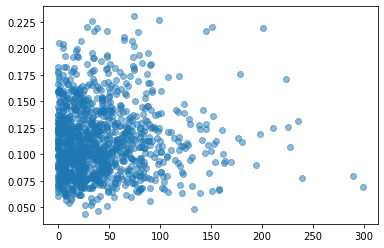

In [496]:
plt.scatter(precip_sums, df_phys_sub.gs, alpha=0.5)

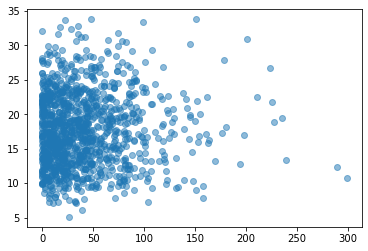

In [493]:
plt.scatter(precip_sums, df_phys_sub.An, alpha=0.5)

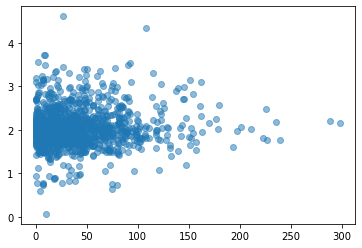

In [494]:
plt.scatter(precip_sums, df_carbon_sub.pn_sum, alpha=0.5)

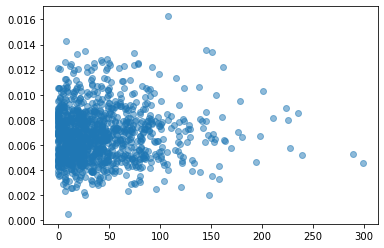

In [495]:
plt.scatter(precip_sums, df_carbon_sub.pn_mean, alpha=0.5)

In [ ]:
plt.plot(test_wea.precip)

In [420]:
pheno_stage = '"Tasselinit"'

cvar = 44
df_climate_sub = df_gseason_climate[df_gseason_climate.pheno == f'{pheno_stage}'].query(f'cvar=={cvar}')
df_phys_sub = df_phys[df_phys.pheno==f'{pheno_stage}'].query(f'cvar=={cvar}')
df_merged_gseason = df_phys_sub.merge(df_wea, on=['site','year'])

df_carbon_sub = df_carbon[df_carbon.pheno==f'{pheno_stage}'].query(f'cvar=={cvar}')
df_carbon_merged = df_carbon_sub.merge(df_wea, on=['site','year'])

df_pheno_sub = df_phenology[df_phenology.pheno == f'{pheno_stage}'].query(f'cvar=={cvar}')


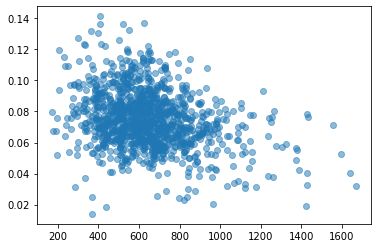

In [421]:
plt.scatter(df_carbon_merged.precip, df_carbon_merged.pn_mean, alpha=0.5)

In [398]:
pheno_stage = '"Emerged"'
df_leaves_sub = df_leaves[df_leaves.pheno==f'{pheno_stage}'].query(f'cvar=={cvar}')
df_leaves_merged = df_leaves_sub.merge(df_wea, on=['site','year'])

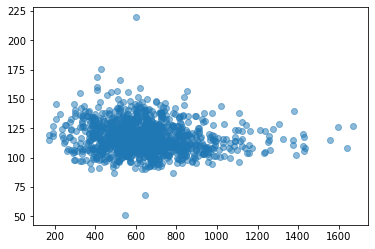

In [399]:
plt.scatter(df_leaves_merged.precip, df_leaves_merged.LA, alpha=0.5)

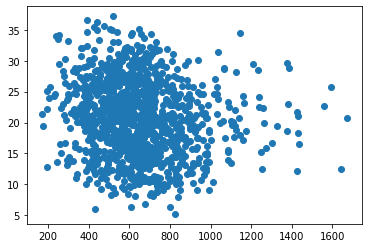

In [406]:
plt.scatter(df_merged_gseason.precip, df_merged_gseason.An)

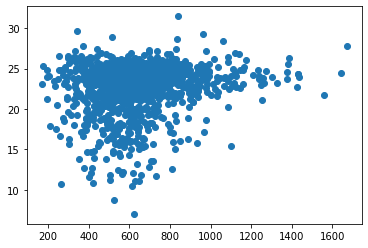

In [378]:
plt.scatter(df_merged_gseason.precip, df_merged_gseason.An)

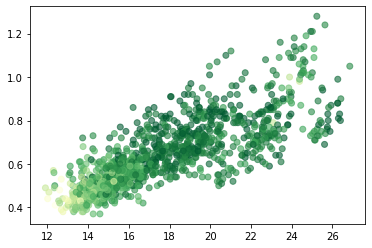

In [181]:
plt.scatter(df_merged.temp, df_merged.vpd, c=df_merged.An,
            cmap=YlGn_8.mpl_colormap, alpha=0.6, vmax=19)

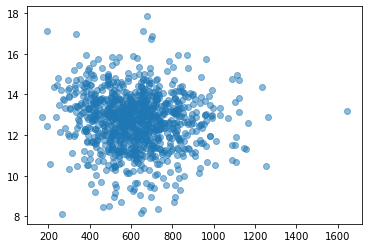

In [168]:
plt.scatter(df_merged.query('temp<22').precip, df_merged.query('temp<22').An, alpha=0.5)

In [94]:
df_all.shape

(112623, 83)

In [96]:
df_wea.head()

site  year   temp  temp_var     rh    rh_var   vpd  precip  precip_var  \
0  724290  1964  17.47  4.184320  65.71  4.857886  0.69   577.9    0.000989   
1  726400  1982  13.22  6.282663  69.12  4.510377  0.47   546.1    0.001160   
2  722340  1961  21.10  2.087655  77.59  5.466569  0.57   845.2    0.001669   
3  724380  1964  17.67  4.173954  68.14  4.588453  0.65   651.4    0.001293   
4  722230  1998  23.48  1.906903  79.40  4.269087  0.61  1388.8    0.003125   

   solrad  solrad_var  
0  220.09  366.640684  
1  205.62  344.164206  
2  226.20  378.008650  
3  217.30  360.636559  
4  237.08  403.697971